In [2]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import time

In [3]:

def get_train_test_data(path: str):
    """ Загрузка данных MNIST
        path - путь до папки с файлами из http://yann.lecun.com/exdb/mnist/
    """
    x_train = idx2numpy.convert_from_file(path + 'train-images.idx3-ubyte')
    x_test = idx2numpy.convert_from_file(path + 't10k-images.idx3-ubyte')

    y_train = idx2numpy.convert_from_file(path + 'train-labels.idx1-ubyte')
    y_test = idx2numpy.convert_from_file(path + 't10k-labels.idx1-ubyte')

    train_size, test_size = x_train.shape[0], x_test.shape[0]

    return x_train, x_test, y_train, y_test

In [5]:
x_train, x_test, y_train, y_test = get_train_test_data('./MNIST/')

Вывод нескольких изображений для подтверждения корректности данных

In [6]:
def draw_digit(Img, digit_true, digit_pred = ''):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(Img, (28, 28)))
    plt.text(0, 27, str(digit_true), color = 'b')
    plt.text(0, 1, str(digit_pred), color = 'r')
    plt.set_cmap('binary')
    # plt.set_cmap('gray')

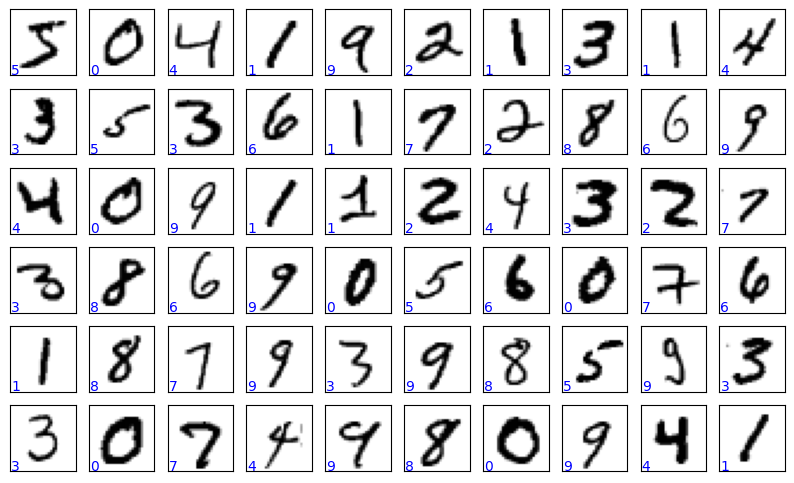

In [7]:
plt.figure(figsize = (10, 6))
for i_subplot in range(60):
    plt.subplot(6, 10, i_subplot + 1)
    draw_digit(x_train[i_subplot], y_train[i_subplot])

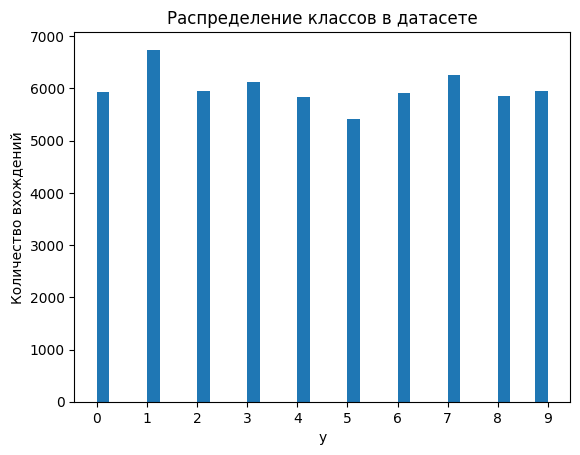

In [8]:
bins = list(set(y_train))
fig, ax = plt.subplots()

ax.hist(y_train, 'auto')
ax.set_xticks(bins)

plt.xlabel("y")
plt.ylabel("Количество вхождений")
plt.title("Распределение классов в датасете")

plt.show()

Параметры нейронной сети

In [9]:
input_size = 28*28
hidden_size = 300
output_size = 10
learning_rate = 0.1
epochs = 20
batch_size = 16

Нормализация данных

In [10]:
x_train = x_train.reshape(-1, input_size)
x_test = x_test.reshape(-1, input_size)

x_train = x_train / 255
x_test = x_test / 255

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Нейронная сеть

In [11]:
def calculate_accuracy(y, y_pred):
    return np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))

In [12]:
class NN:
    def __init__(self, input_size, hidden_size, out_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.learning_rate = learning_rate

        std1 = np.sqrt(2. / hidden_size)
        std2 = np.sqrt(2. / out_size)
        # первый слой
        self.w1 = np.random.normal(0.0, std1, size=(input_size, hidden_size))
        self.b1 = np.random.normal(0.0, std1, size=(1, hidden_size))
        # второй слой
        self.w2 = np.random.normal(0.0, std2, size=(hidden_size, out_size))
        self.b2 = np.random.normal(0.0, std2, size=(1, out_size))

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def d_relu(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def softmax(x):
        exp = np.exp(x)
        return exp/np.sum(exp, axis = 1, keepdims = True)

    @staticmethod
    def layer(x, w, b):
        return np.matmul(x, w) + b

    @staticmethod
    def compute_cross_entropy(y, y_pred):
        return np.mean(-np.sum(y * np.log(y_pred), axis=1))

    @staticmethod
    def unison_shuffled_copies(a, b):
        p = np.random.permutation(len(a))
        return a[p], b[p]

    @staticmethod
    def get_time():
        t = time.localtime()
        # Время по МСК
        return f"{t.tm_hour+3}:{time.strftime('%M:%S', t)}"

    def optimizer_param_step(self, l, dl):
        l -= self.learning_rate * dl

    def forward(self, x):
        self.hidden1 = self.layer(x, self.w1, self.b1)
        self.relu_layer = self.relu(self.hidden1)
        self.hidden2 = self.layer(self.relu_layer, self.w2, self.b2)
        return self.softmax(self.hidden2)

    def backward(self, x, y_true):
        y_pred = self.forward(x)

        d_hidden2 = (y_pred - y_true) / x.shape[0]
        dw2 = np.matmul(self.relu_layer.T, d_hidden2)
        db2 = np.sum(d_hidden2, axis = 0, keepdims = True)

        d_hidden1 = np.matmul(d_hidden2, self.w2.T) * self.d_relu(self.hidden1)
        dw1 = np.matmul(x.T, d_hidden1)
        db1 = np.sum(d_hidden1, axis = 0, keepdims = True)

        # изменение весов
        self.optimizer_param_step(self.w1, dw1)
        self.optimizer_param_step(self.w2, dw2)
        # изменение смещений
        self.optimizer_param_step(self.b1, db1)
        self.optimizer_param_step(self.b2, db2)

    def predict(self, x):
        return self.forward(x)

    def train(self, x, y_true, epochs = 20, batch_size = 8):
        for epoch in range(epochs):
            x, y_true = self.unison_shuffled_copies(x, y_true)
            start_time = time.time()
            for i in range(0, len(x), batch_size):
                x_batch = x[i:i + batch_size]
                y_batch = y_true[i:i + batch_size]
                self.backward(x_batch, y_batch)

            y_pred = self.predict(x)
            accuracy = calculate_accuracy(y_true, y_pred)
            diff_time = time.time() - start_time
            print(f"[{self.get_time()}] \t Epoch: {epoch + 1}/{epochs} \t accuracy: {accuracy:.4f} \t Time: {diff_time:.2f}")


Результаты

In [13]:
nn = NN(input_size = input_size, hidden_size = hidden_size,
        out_size = output_size, learning_rate = learning_rate)

nn.train(x_train, y_train, epochs, batch_size)

[16:03:23] 	 Epoch: 1/20 	 accuracy: 0.9746 	 Time: 17.43
[16:03:34] 	 Epoch: 2/20 	 accuracy: 0.9818 	 Time: 10.92
[16:03:45] 	 Epoch: 3/20 	 accuracy: 0.9877 	 Time: 10.67
[16:03:53] 	 Epoch: 4/20 	 accuracy: 0.9919 	 Time: 7.87
[16:04:04] 	 Epoch: 5/20 	 accuracy: 0.9947 	 Time: 10.70
[16:04:14] 	 Epoch: 6/20 	 accuracy: 0.9938 	 Time: 9.59
[16:04:22] 	 Epoch: 7/20 	 accuracy: 0.9978 	 Time: 8.62
[16:04:34] 	 Epoch: 8/20 	 accuracy: 0.9990 	 Time: 11.85
[16:04:46] 	 Epoch: 9/20 	 accuracy: 0.9994 	 Time: 11.53
[16:04:54] 	 Epoch: 10/20 	 accuracy: 0.9998 	 Time: 7.83
[16:05:05] 	 Epoch: 11/20 	 accuracy: 0.9999 	 Time: 10.77
[16:05:15] 	 Epoch: 12/20 	 accuracy: 0.9999 	 Time: 10.19
[16:05:24] 	 Epoch: 13/20 	 accuracy: 1.0000 	 Time: 8.12
[16:05:35] 	 Epoch: 14/20 	 accuracy: 1.0000 	 Time: 10.93
[16:05:44] 	 Epoch: 15/20 	 accuracy: 1.0000 	 Time: 9.30
[16:05:53] 	 Epoch: 16/20 	 accuracy: 1.0000 	 Time: 9.00
[16:06:04] 	 Epoch: 17/20 	 accuracy: 1.0000 	 Time: 10.88
[16:06:13] 	 

In [14]:
y_pred = nn.predict(x_test)
accuracy = calculate_accuracy(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9820
